Dataset shape: (1797, 64), Number of classes: 10
Reduced dimension with PCA: 25
Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [08:29:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV accuracy: 0.940164
Best hyperparameters: {'colsample_bytree': np.float64(0.6092249700165663), 'learning_rate': np.float64(0.16743239807751675), 'max_depth': 9, 'n_estimators': 269, 'reg_alpha': np.float64(0.04666566321361543), 'reg_lambda': np.float64(2.4475110376829186), 'subsample': np.float64(0.6931085361721216)}
Test accuracy: 0.930556

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        36
           1       0.82      0.92      0.87        36
           2       0.94      0.94      0.94        35
           3       0.95      0.97      0.96        37
           4       0.95      0.97      0.96        36
           5       0.92      0.92      0.92        37
           6       0.95      1.00      0.97        36
           7       0.94      0.94      0.94        36
           8       0.94      0.86      0.90        35
           9       0.91      0.83      0.87        36

    accuracy                 

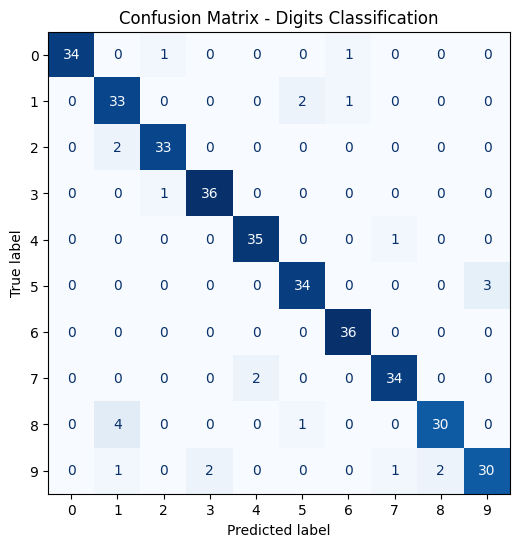

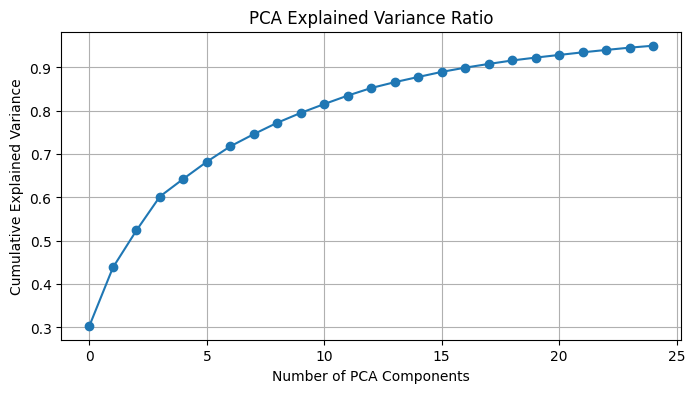

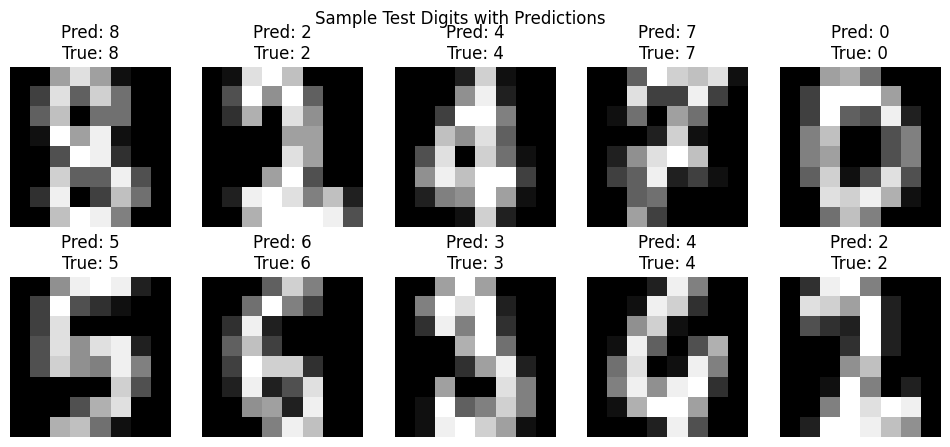

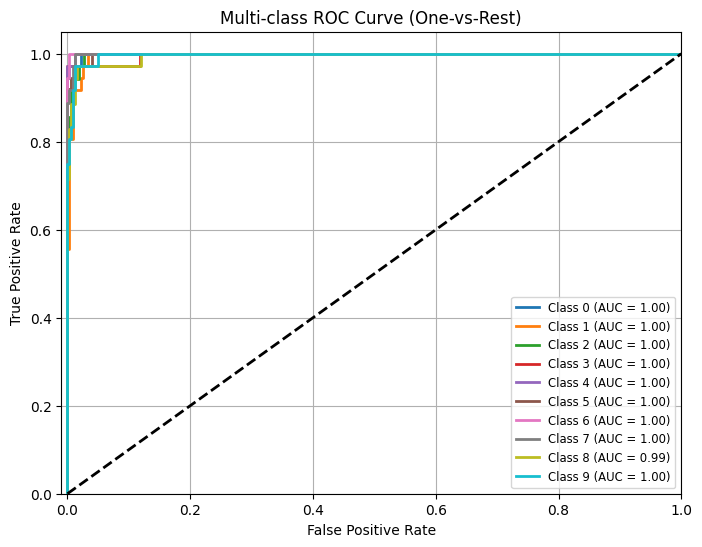

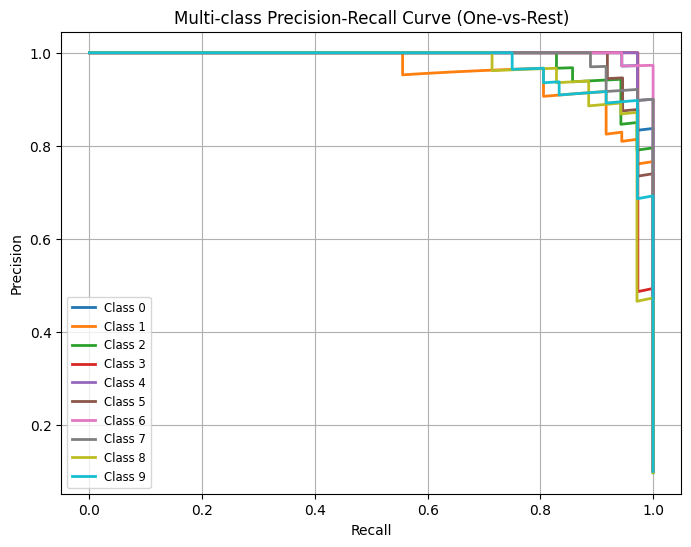

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
)
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from sklearn.preprocessing import label_binarize

# 1. Load dataset
digits = load_digits()
X, y = digits.data, digits.target
print(f"Dataset shape: {X.shape}, Number of classes: {len(np.unique(y))}")

# 2. Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Preprocessing
# Scale with RobustScaler (less sensitive to outliers)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Optional: PCA to reduce dimensionality, improve speed and possibly accuracy
pca = PCA(n_components=0.95, random_state=42)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"Reduced dimension with PCA: {X_train_pca.shape[1]}")

# 4. Model and Hyperparameter tuning with RandomizedSearchCV
base_model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42,
)

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.3),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0, 1),
    "reg_lambda": uniform(0.5, 2),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    n_iter=40,
    scoring="accuracy",
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1,
)

search.fit(X_train_pca, y_train)

print(f"Best CV accuracy: {search.best_score_:.6f}")
print(f"Best hyperparameters: {search.best_params_}")

best_model = search.best_estimator_

# 5. Evaluate on test set
y_pred = best_model.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.6f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# 6. Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=digits.target_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - Digits Classification")
plt.show()

# ==============================
# Additional Visualizations
# ==============================

# 7. PCA Explained Variance Plot
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of PCA Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance Ratio")
plt.grid(True)
plt.show()

# 8. Sample Digits Visualization 
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
indices = np.random.choice(len(X_test), 10, replace=False)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_test[indices[i]].reshape(8, 8), cmap='gray')
    ax.set_title(f"Pred: {y_pred[indices[i]]}\nTrue: {y_test.iloc[indices[i]] if hasattr(y_test, 'iloc') else y_test[indices[i]]}")
    ax.axis('off')
plt.suptitle("Sample Test Digits with Predictions")
plt.show()

# 9. ROC Curve for multi-class (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=np.arange(10))
y_score = best_model.predict_proba(X_test_pca)

plt.figure(figsize=(8, 6))
for i in range(10):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.show()

# 10. Precision-Recall Curve for multi-class (One-vs-Rest)
plt.figure(figsize=(8, 6))
for i in range(10):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve (One-vs-Rest)")
plt.legend(loc="lower left", fontsize='small')
plt.grid(True)
plt.show()
